# Example with tidal flume

In this simulation that seems to mimic a lab experiment, there is a long channel with one tidally forced boundary
on the left. At inflow on the left boundary salt sea-water will intrude into the channel. The channel is 130m
long, 1m wide and 20 cm deep. The "tide" on the left bounday has a period of 10 minutes and an amplitude of 0.75 cm. The inflowing water has a salinity of 12.5 psu. The net inflow on the right boundary is 0.005 m^3/s.
The simulation starts at rest with fresh water in the entire basin and finishes after 100 minutes, equaling 10 cycles.


In [1]:
# Load required libraries
using Pkg
Pkg.precompile() # command needed after modifying the src code
Pkg.activate("..")
using Particles
using Plots
using Random
using LaTeXStrings
using ZipFile
using DelimitedFiles

randpool = MersenneTwister(0) #Generate same random numbers every time

nothing

Precompiling project...


  ✓ Particles
  1 dependency successfully precompiled in 35 seconds. 277 already precompiled.


  Activating project at `d:\Projects\particles.jl`


In [2]:
using DelimitedFiles


In [3]:
# unzip the flow data (if not already done)

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

if !isdir("./data/tidal_flume_map.zarr") 
    unzip("./data/tidal_flume_map.zip","./data")
end


In [66]:
# Load default settings and adjust

# collected configuration is in Dict d
d = default_userdata() # start with some defaults

# settings for this experiment
n = 0 # number of particles
d["nparticles"] = n
# problem specific settings
x_min_release = 10. # release particles in this znode
d["x_min_release"] = x_min_release
x_max_release = 10.
d["x_max_release"] = x_max_release
z_min_release = -0.2  
d["z_min_release"] = z_min_release
z_max_release = -0.003
d["z_max_release"] = z_max_release
y_release = 1.0
d["y_release"] = y_release 

# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = x_min_release .+ (x_max_release - x_min_release) .* rand(randpool, n, 1) # x
p[2, :] .= y_release # y
p[3, :] = z_min_release .+ (z_max_release - z_min_release) .* rand(randpool, n, 1) # z
p[4, :] .= 0.0 # age
d["particles"] = p # initial values
# simulation time
d["dt"] = 1.0     #time-step
d["tstart"] = 1200 #start after 2 cycles
d["tend"]   = 1800 #3600.0
tstart=d["tstart"] 
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:30.0:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_tidal_flume.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:30.0:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(tstart:30.0:tend)

d #show configuration

Dict{String, Any} with 29 entries:
  "plot_maps_prefix"     => "map"
  "write_maps"           => false
  "reftime"              => DateTime("2000-01-01T00:00:00")
  "particles"            => Matrix{Float64}(undef, 4, 0)
  "nparticles"           => 0
  "plot_maps_times"      => [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0,…
  "dt"                   => 1.0
  "tend"                 => 1800
  "write_maps_dir"       => "."
  "write_maps_filename"  => "output_tidal_flume.nc"
  "z_min_release"        => -0.2
  "variables"            => ["x", "y", "z", "age"]
  "x_min_release"        => 10.0
  "keep_particle_times"  => [1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 13…
  "dumval"               => 9999.0
  "write_maps_as_series" => true
  "keep_particles"       => true
  "z_max_release"        => -0.003
  "plot_maps_func"       => plot_maps_xz
  ⋮                      => ⋮

Two test cases are embedded.
The first test case tests the algorithm that divides the timestep by half, takes a new random number and thus weakens the strength of diffusion strength and "controlls" the direction of turbulent velocity. To test the algorithm, we only add one particle into the computation domain and set the keyword parameter `d["if_cross_bc"] = false` and `d["if_apply_cross_bc_test"] = true`.

In [67]:
# the following options are to be added in the default_userdata() function
# if to apply the algorithm to prevent the algorithm from crossing the boundary or not
d["is_cross_bc"] = false # if added, the algorithm will terminate once the particle is out of the boundary
d["is_apply_cross_bc_test"] = false # if applied, only one particle is used and all virtual trajectories are also recorded
if d["is_apply_cross_bc_test"]
    d["the_virtual_trajectory"] = d["particles"]
end
# to be added according to the actual problem
d["is_particle_in_domain"] = x -> nothing
d["isactive_particles"] = trues(d["nparticles"],) # check if particles move out of the is_particle_in_domain
d["recursion_depth"] = 10

# Randompool setup and restart
randpool = MersenneTwister(123) #Generate same random numbers every time
d["rng"] = randpool


MersenneTwister(123)

In [68]:
# Load flow data and create interpolators

Zarr_data = ZarrData("./data","tidal_flume_map.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
function v(x,y,z,t) # interpolation of v is implemented but gives no useful addition to the zeros below
    return 0.0
end
function w(x,y,z,t) #TODOLIST make interpolation of w work
    return 0.0
end
s=initialize_interpolation(Zarr_data,"salinity",t0)

nothing

In [69]:
# no use for now because two plots will be integrated into one plot with two subplots
x_left = 9.0
x_right = 130.0
y_middle = 1.0
z_surface = -0.003

z_bottom = -0.2
t_start=1200.0 #Skip first 20 minutes -= 2 cycles
t_step=30.0 # 6s in file, here coarser
t_stop=d["tend"]#max 100minutes=6000s with steps 6s / period is 600s


# problem specific setting
IS_USE_RK4 = false
# compulsory input
# add particles into the domain 
# the particles are only released at integer numbers of time instant
N_grid = 10
d["x_left"] = 9.
d["dx"] = 8.
d["xc_left"] = d["x_left"] + d["dx"]/2

d["nparticles_bound"] = 200000
d["particles"] = zeros(length(variables), d["nparticles_bound"])
d["first_active_index"] = 1
d["first_inactive_index"] = 1
d["isactive_particles"] = falses(d["nparticles_bound"],)

x_bccell =[d["x_left"], d["x_left"]+d["dx"]]
x_points = d["x_left"]:d["dx"]:x_right
z_points = range(z_bottom, z_surface, length=N_grid+1) 

Npart_per_salinity = 20

dirname = "flux"



"flux"

In [70]:
# # create an animation of the flow field

# #grid for plotting arrows
# xgrid=collect(range(0,x_right,length=20))
# zgrid=collect(range(z_bottom,z_surface,length=10))
# nx=length(xgrid)
# nz=length(zgrid)
# xs=repeat(xgrid,1,nz)
# zs=repeat(zgrid,1,nx)'

# anim = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
#     # grid for plotting only
#     x_points = range(x_left,stop=x_right,length=130)
#     z_points = range(z_bottom,stop=z_surface,length=100)
#     #u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
#     s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
#     h_interp = [h(x,y_middle,0.0,t) for x in x_points] # water level

#     #l = @layout([a; b])
#     #p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity time=\$(t)",clims=(-0.5,0.5))
#     p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity after \$(t/600.0) cycles",clims=(0,15),color=:dense)
#     quiver!(p2,vec(xs),vec(zs),quiver=(u.(vec(xs),y_middle,vec(zs),t),w.(vec(xs),y_middle,vec(zs),t)), arrowscale=0.6, headsize=0.1)
#     #plot(p1,p2,layout=l,size=(800,300))
#     plot!(p2,x_points,h_interp,label=false,linewidth=2,color=:black)
#     plot(p2,size=(800,300))
# end

# gif(anim, "./tidal_flume.gif", fps = 1)

# nothing

In [71]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes as ds the function f in the equation ds=f(s,t)dt+g(s,t)dw 
for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
# add a function f that can apply RK4 
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   if IS_USE_RK4
      dt = d["dt"]
      k1 = u(x,y,z,t)
      l1 = v(x,y,z,t)
      m1 = w(x,y,z,t)
      k2 = u(x+1.0/2*dt*k1, y+1.0/2*dt*l1, z+1.0/2*dt*m1, t+1.0/2*dt)
      l2 = v(x+1.0/2*dt*k1, y+1.0/2*dt*l1, z+1.0/2*dt*m1, t+1.0/2*dt)
      m2 = w(x+1.0/2*dt*k1, y+1.0/2*dt*l1, z+1.0/2*dt*m1, t+1.0/2*dt)
      k3 = u(x+1.0/2*dt*k2, y+1.0/2*dt*l2, z+1.0/2*dt*m2, t+1.0/2*dt)
      l3 = v(x+1.0/2*dt*k2, y+1.0/2*dt*l2, z+1.0/2*dt*m2, t+1.0/2*dt)
      m3 = w(x+1.0/2*dt*k2, y+1.0/2*dt*l2, z+1.0/2*dt*m2, t+1.0/2*dt)
      k4 = u(x+dt*k3,      y+dt*l3,      z+dt*m3,      t+dt)
      l4 = v(x+dt*k3,      y+dt*l3,      z+dt*m3,      t+dt)
      m4 = w(x+dt*k3,      y+dt*l3,      z+dt*m3,      t+dt)
      # dx/dt=u
      ∂s.x = 1.0/6*(k1+2*k2+2*k3+k4)
      # dy/dt=v
      ∂s.y = 1.0/6*(l1+2*l2+2*l3+l4)
      # dz/dt=0
      ∂s.z = 1.0/6*(m1+2*m2+2*m3+m4)
      # age=(t-t0)
      ∂s.t = 1.0      
   else
      # dx/dt=u
      ∂s.x = u(x, y, z, t)
      # dy/dt=v
      ∂s.y = v(x, y, z, t)
      # dz/dt=0
      ∂s.z = w(x, y, z, t)
      # age=(t-t0)
      ∂s.t = 1.0
   end
end
d["f"] = f!

#
# TODO: add function g! to simulate diffusion to simulation routine
#

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
    ∂s.x = 0.0
   # dy/dt=v
    ∂s.y = 0.0
   # dz/dt=0
    ∂s.z = 0.0
   # age=(t-t0)
    ∂s.t = 0.0
end
d["g"] = g!

g! (generic function with 1 method)

In [72]:
# compulsory input             
function is_particle_in_domain(p)
    x,y,z,t = p
    is_inside_xdir = x_left ≤ x ≤ x_right
    is_inside_ydir = true
    is_inside_zdir = z_bottom ≤ z ≤ h(x,y_middle,z,t)
    is_apply_reflection = !is_inside_zdir            # in the tidal flume case, only particles going from above or below shall be reflected
    return is_inside_xdir && is_inside_zdir, is_apply_reflection 
end
d["is_particle_in_domain"] = is_particle_in_domain


is_particle_in_domain (generic function with 1 method)

In [73]:
function calculate_Npart_field(x_points, z_points, particles, isactivelist)
    # return concentration field defined in specified cell centers
    active_particles_indexes = findall(isactivelist)
    Npart_field = zeros(length(z_points)-1, length(x_points)-1)
    for i in active_particles_indexes
        isindomain,_ = is_particle_in_domain(particles[:, i])
        if isindomain
            x, _, z, t = particles[:,i]
            box_xindex = findfirst(var->x<var, x_points) # terminate searching at the first hit
            box_zindex = findfirst(var->z<var, z_points) 
            if !isnothing(box_xindex) 
                Npart_field[box_zindex-1, box_xindex-1] += 1 # index match the upperbound, so minus 1 here
            end
        end
    end
    return Npart_field
end

calculate_Npart_field (generic function with 1 method)

In [74]:
for i in 1200:30:1800
    println(u(d["x_left"], y_middle, -0.1, i))
end

0.09569615384615399
0.16352307692307713
0.24160769230769244
0.25654230769230774
0.252
0.22549999999999998
0.15949999999999998
0.05799999999999998
-0.05756538461538463
-0.16356538461538464
-0.25863076923076916
-0.31063076923076915
-0.31863076923076916
-0.2935653846153845
-0.24843461538461525
-0.19167307692307678
-0.12236923076923063
-0.04980384615384604
0.02019615384615396
0.09013076923076938


0.15856538461538475


In [75]:
function release_particles_flux(d, p, t)
    get_release(t) = true # check if release particles at this instant
    is_release_now = get_release(t)
    zc_points = (z_points[1:end-1] + z_points[2:end]) ./ 2
    zc_length = length(zc_points)
    if is_release_now
        # release particles accordingly
        uprof_boundary = [u(d["x_left"], y_middle, z, t) for z in zc_points]
        is_release_this_cell = uprof_boundary .> 1e-10
        for i =1:length(is_release_this_cell)
            id = d["first_inactive_index"]
            if is_release_this_cell[i]
                # calculate intrusion length
                L_intrude = uprof_boundary[i] * d["dt"]
                npart_release = L_intrude/d["dx"] * s(d["x_left"], y_middle, zc_points[i], t) * Npart_per_salinity
                if npart_release < 0.1
                    continue
                else
                    npart_release = ceil(Int, npart_release)
                end
                indices = (id: id+npart_release-1)
                d["isactive_particles"][indices] .= true
                p[1,indices] = d["x_left"] .+ L_intrude*rand(randpool, npart_release,1)
                p[2,indices] .= y_middle 
                p[3,indices] = z_points[i] .+ (z_points[i+1]-z_points[i])*rand(randpool, npart_release,1)
                p[4,indices] .= 0
                d["first_inactive_index"] += npart_release
            end
        end
        if d["first_active_index"] == 1
            d["first_active_index"] = findfirst(d["isactive_particles"])
        else
            d["first_active_index"] = findnext(d["isactive_particles"],d["first_active_index"]-1) # adjust to the case of unchanged index 
        end
    end
    return p
end
d["release_particles"] = release_particles_flux

release_particles_flux (generic function with 1 method)

In [76]:
# function release_particles(d, p, t)
#     get_release(t) = true # check if release particles at this instant
#     is_release_now = get_release(t)
#     if is_release_now
#         # check current concentration
#         Npart_field_real = calculate_Npart_field(x_bccell, z_points, p, d["isactive_particles"])
#         # check expected concentration
#         zc_points = (z_points[1:end-1] + z_points[2:end])/2
#         Npart_field_force = [s(d["xc_left"], y_middle, z, t) for z in zc_points] .* Npart_per_salinity # 1 unit salinity (computed by per unit area) is represented by 10 particles
#         # release particles accordingly
#         is_release_this_cell = (Npart_field_force .- Npart_field_real) .> 1e-10
#         for i =1:length(is_release_this_cell)
#             id = d["first_inactive_index"]
#             if is_release_this_cell[i]
#                 # release particle here
#                 npart_release = ceil(Int, Npart_field_force[i] - Npart_field_real[i])
#                 indices = (id: id+npart_release-1)
#                 d["isactive_particles"][indices] .= true
#                 p[1,indices] = d["x_left"] .+ d["dx"]*rand(randpool, npart_release,1)
#                 p[2,indices] .= y_middle 
#                 p[3,indices] = z_points[i] .+ (z_points[i+1]-z_points[i])*rand(randpool, npart_release,1)
#                 p[4,indices] .= 0
#                 d["first_inactive_index"] += npart_release
#             else
#                 # remove particles (one by one) here 
#                 npart_remove = ceil(Int, Npart_field_real[i] - Npart_field_force[i])
#                 startid = d["first_active_index"]
#                 # find the range of the box
#                 isinside_xdir(x) = d["x_left"] <= x <= d["x_left"] + d["dx"]
#                 isinside_ydir(y) = true
#                 isinside_zdir(z) = z_points[i] <= z <= z_points[i+1]
#                 for i=1:npart_remove
#                     keep_search = true
#                     while(keep_search)
#                         xid = findnext(isinside_xdir, p[1,:], startid)
#                         yid = findnext(isinside_ydir, p[2,:], startid)
#                         zid = findnext(isinside_zdir, p[3,:], startid)
#                         startid = maximum([xid,yid,zid])
#                         if isinside_xdir(p[1,startid]) && isinside_ydir(p[2,startid]) && isinside_zdir(p[3,startid])
#                             keep_search = false
#                         end
#                     end
#                     d["isactive_particles"][startid] = false
#                 end
#             end
#         end
#         if d["first_active_index"] == 1
#             d["first_active_index"] = findfirst(d["isactive_particles"])
#         else
#             d["first_active_index"] = findnext(d["isactive_particles"],d["first_active_index"]-1) # adjust to the case of unchanged index 
#         end
#     end
#     return p
# end
# d["release_particles"] = release_particles

In [77]:
function initialize_particles(d, p)
    Npart_field_real = calculate_Npart_field(x_points, z_points, p, d["isactive_particles"])
    # check expected concentration
    xc_points = (x_points[1:end-1]+x_points[2:end]) ./ 2
    xc_length = length(xc_points)
    zc_points = (z_points[1:end-1] + z_points[2:end]) ./ 2
    zc_length = length(zc_points)
    deltax = d["dx"]
    deltaz = abs(zc_points[2] - zc_points[1])
    Npart_field_force = [s(x, y_middle, z, d["tstart"]) for z in zc_points, x in xc_points] .* Npart_per_salinity # 1 unit salinity (computed by per unit area) is represented by 10 particles
    # release particles accordingly
    is_release_this_cell = (Npart_field_force .- Npart_field_real) .> 1e-10 
    cell_xindex = 1
    cell_zindex = 0
    for i =1:length(is_release_this_cell)
        id = d["first_inactive_index"]
        cell_zindex += 1
        if cell_zindex > zc_length
            cell_zindex = 1
            cell_xindex += 1
        end
        if is_release_this_cell[i]
            # locate the cell center
            x = x_points[cell_xindex] # Index of cell center number = Index of cell left bound
            z = z_points[cell_zindex]
            # release particle here
            npart_release = ceil(Int, Npart_field_force[i] - Npart_field_real[i])
            indices = (id: id+npart_release-1)
            d["isactive_particles"][indices] .= true
            p[1,indices] = x .+ deltax*rand(randpool, npart_release,1)
            p[2,indices] .= y_middle 
            p[3,indices] = z .+ deltaz*rand(randpool, npart_release,1)
            p[4,indices] .= 0
            d["first_inactive_index"] += npart_release
        end
    end
    # check current concentration
    d["first_active_index"] = findfirst(d["isactive_particles"]) # to be commented
    return p
end
d["initialize_particles"] = initialize_particles

initialize_particles (generic function with 1 method)

In [79]:
#run the actual particle model

@time run_simulation(d)

writing output to memory at t = [1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0  …  1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0]
interrupt simulation for output at t = [1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0  …  1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0]
Simulation from time 1200s to 1800s since 2000-01-01T00:00:00
t=1200 -> 1200.0  : 2000-01-01T00:20:00 -> 2000-01-01T00:20:00 : 0.0%
Before this updating, the number of active particle is 0.
Before this updating, the number of released particles is 0. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


Particles initialization finish!
simulate! runs for once.
t=1200 -> 1230.0  : 2000-01-01T00:20:00 -> 2000-01-01T00:20:30 : 5.0%
Before this updating, the number of active particle is 1405.
Before this updating, the number of released particles is 0. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1230.0 -> 1260.0  : 2000-01-01T00:20:30 -> 2000-01-01T00:21:00 : 10.0%
Before this updating, the number of active particle is 2196.
Before this updating, the number of released particles is 2163. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1260.0 -> 1290.0  : 2000-01-01T00:21:00 -> 2000-01-01T00:21:30 : 15.0%
Before this updating, the number of active particle is 3532.
Before this updating, the number of released particles is 3478. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1290.0 -> 1320.0  : 2000-01-01T00:21:30 -> 2000-01-01T00:22:00 : 20.0%
Before this updating, the number of active particle is 5555.
Before this updating, the number of released particles is 5478. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1320.0 -> 1350.0  : 2000-01-01T00:22:00 -> 2000-01-01T00:22:30 : 25.0%
Before this updating, the number of active particle is 7865.
Before this updating, the number of released particles is 7788. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1350.0 -> 1380.0  : 2000-01-01T00:22:30 -> 2000-01-01T00:23:00 : 30.0%
Before this updating, the number of active particle is 10143.
Before this updating, the number of released particles is 10070. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1380.0 -> 1410.0  : 2000-01-01T00:23:00 -> 2000-01-01T00:23:30 : 35.0%
Before this updating, the number of active particle is 12068.
Before this updating, the number of released particles is 12014. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1410.0 -> 1440.0  : 2000-01-01T00:23:30 -> 2000-01-01T00:24:00 : 40.0%
Before this updating, the number of active particle is 13234.
Before this updating, the number of released particles is 13210. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1440.0 -> 1470.0  : 2000-01-01T00:24:00 -> 2000-01-01T00:24:30 : 45.0%
Before this updating, the number of active particle is 13248.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1470.0 -> 1500.0  : 2000-01-01T00:24:30 -> 2000-01-01T00:25:00 : 50.0%
Before this updating, the number of active particle is 12101.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1500.0 -> 1530.0  : 2000-01-01T00:25:00 -> 2000-01-01T00:25:30 : 55.0%
Before this updating, the number of active particle is 10081.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1530.0 -> 1560.0  : 2000-01-01T00:25:30 -> 2000-01-01T00:26:00 : 60.0%
Before this updating, the number of active particle is 7236.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1560.0 -> 1590.0  : 2000-01-01T00:26:00 -> 2000-01-01T00:26:30 : 65.0%
Before this updating, the number of active particle is 5107.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1590.0 -> 1620.0  : 2000-01-01T00:26:30 -> 2000-01-01T00:27:00 : 70.0%
Before this updating, the number of active particle is 3125.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1620.0 -> 1650.0  : 2000-01-01T00:27:00 -> 2000-01-01T00:27:30 : 75.0%
Before this updating, the number of active particle is 1844.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1650.0 -> 1680.0  : 2000-01-01T00:27:30 -> 2000-01-01T00:28:00 : 80.0%
Before this updating, the number of active particle is 1186.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.
simulate! runs for once.


t=1680.0 -> 1710.0  : 2000-01-01T00:28:00 -> 2000-01-01T00:28:30 : 85.0%
Before this updating, the number of active particle is 851.
Before this updating, the number of released particles is 13452. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1710.0 -> 1740.0  : 2000-01-01T00:28:30 -> 2000-01-01T00:29:00 : 90.0%
Before this updating, the number of active particle is 772.
Before this updating, the number of released particles is 13461. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1740.0 -> 1770.0  : 2000-01-01T00:29:00 -> 2000-01-01T00:29:30 : 95.0%
Before this updating, the number of active particle is 903.
Before this updating, the number of released particles is 13589. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
t=1770.0 -> 1800.0  : 2000-01-01T00:29:30 -> 2000-01-01T00:30:00 : 100.0%
Before this updating, the number of active particle is 1274.
Before this updating, the number of released particles is 13949. 
The number of active particles and released particles immediately after initializing are different because the latter is determined through residence time greater than zero, so this involves a delay.


simulate! runs for once.
302.197768 seconds (1.11 G allocations: 60.047 GiB, 10.08% gc time, 0.47% compilation time)


In [80]:
t_start

1200.0

In [81]:
t_stop

1800

In [83]:
# create an profile of the u-velocity at certain x direction
#t_points = range(t_start, stop = t_stop-t_step, step = t_step)
#z_points = range(z_bottom,stop=z_surface,length=100)

#for xcor in range(20, 60, step=10)
#    anim_upf = @animate for t in range(t_start, stop = t_stop-t_step, step = t_step)
#        plot([u(xcor,y_middle,z,t) for z in z_points], z_points, xlabel="velocity u",ylabel="position z ",title="uvel at x=$(xcor) t=$(t)s", xlim=(-0.4,0.3), left_margin = 5Plots.mm, bottom_margin = 15Plots.mm, right_margin = 5Plots.mm, top_margin = 15Plots.mm, size=(600,600))
#    end

#    gif(anim_upf, "./result/uvel_x=$(xcor).gif", fps = 20)
#end

nothing


At t=1200.0, smass_approx=4.6886, smass_true=4.642840776194337


At t=1230.0, smass_approx=8.794080000000001, smass_true=6.994488059481789


At t=1260.0, smass_approx=14.68832, smass_true=13.358887693890122


At t=1290.0, smass_approx=25.948839999999997, smass_true=24.200055971845508


At t=1320.0, smass_approx=41.34636, smass_true=38.35806976232969


At t=1350.0, smass_approx=58.76904, smass_true=54.143222168190775


At t=1380.0, smass_approx=73.52040000000001, smass_true=66.77366950944923


At t=1410.0, smass_approx=82.19628, smass_true=74.43665947020985


At t=1440.0, smass_approx=82.36964, smass_true=74.55966933155024


At t=1470.0, smass_approx=74.1114, smass_true=67.09148872480911


At t=1500.0, smass_approx=58.674479999999996, smass_true=52.81853170080733


At t=1530.0, smass_approx=41.890080000000005, smass_true=36.30876987693891


At t=1560.0, smass_approx=25.042640000000002, smass_true=21.39633815026722


At t=1590.0, smass_approx=12.91532, smass_true=10.44099309022149


At t=1620.0, smass_approx=6.52464, smass_true=3.5639882905726536


At t=1650.0, smass_approx=2.88408, smass_true=1.0157978754529926


At t=1680.0, smass_approx=0.85892, smass_true=0.011091403076923113


At t=1710.0, smass_approx=0.26792000000000005, smass_true=0.0


At t=1740.0, smass_approx=0.31520000000000004, smass_true=0.0


At t=1770.0, smass_approx=2.10396, smass_true=0.0009940923076923098

┌ Info: Saved animation to d:\Projects\particles.jl\case_tidal_flume\flux\s_RK4=false_dx=8.0_dt=1.0_N_grid=10.gif
└ @ Plots C:\Users\hugo1\.julia\packages\Plots\3BCH5\src\animation.jl:156
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
origin outside current window


Plots.AnimatedGif("d:\\Projects\\particles.jl\\case_tidal_flume\\flux\\s_RK4=false_dx=8.0_dt=1.0_N_grid=10.gif")
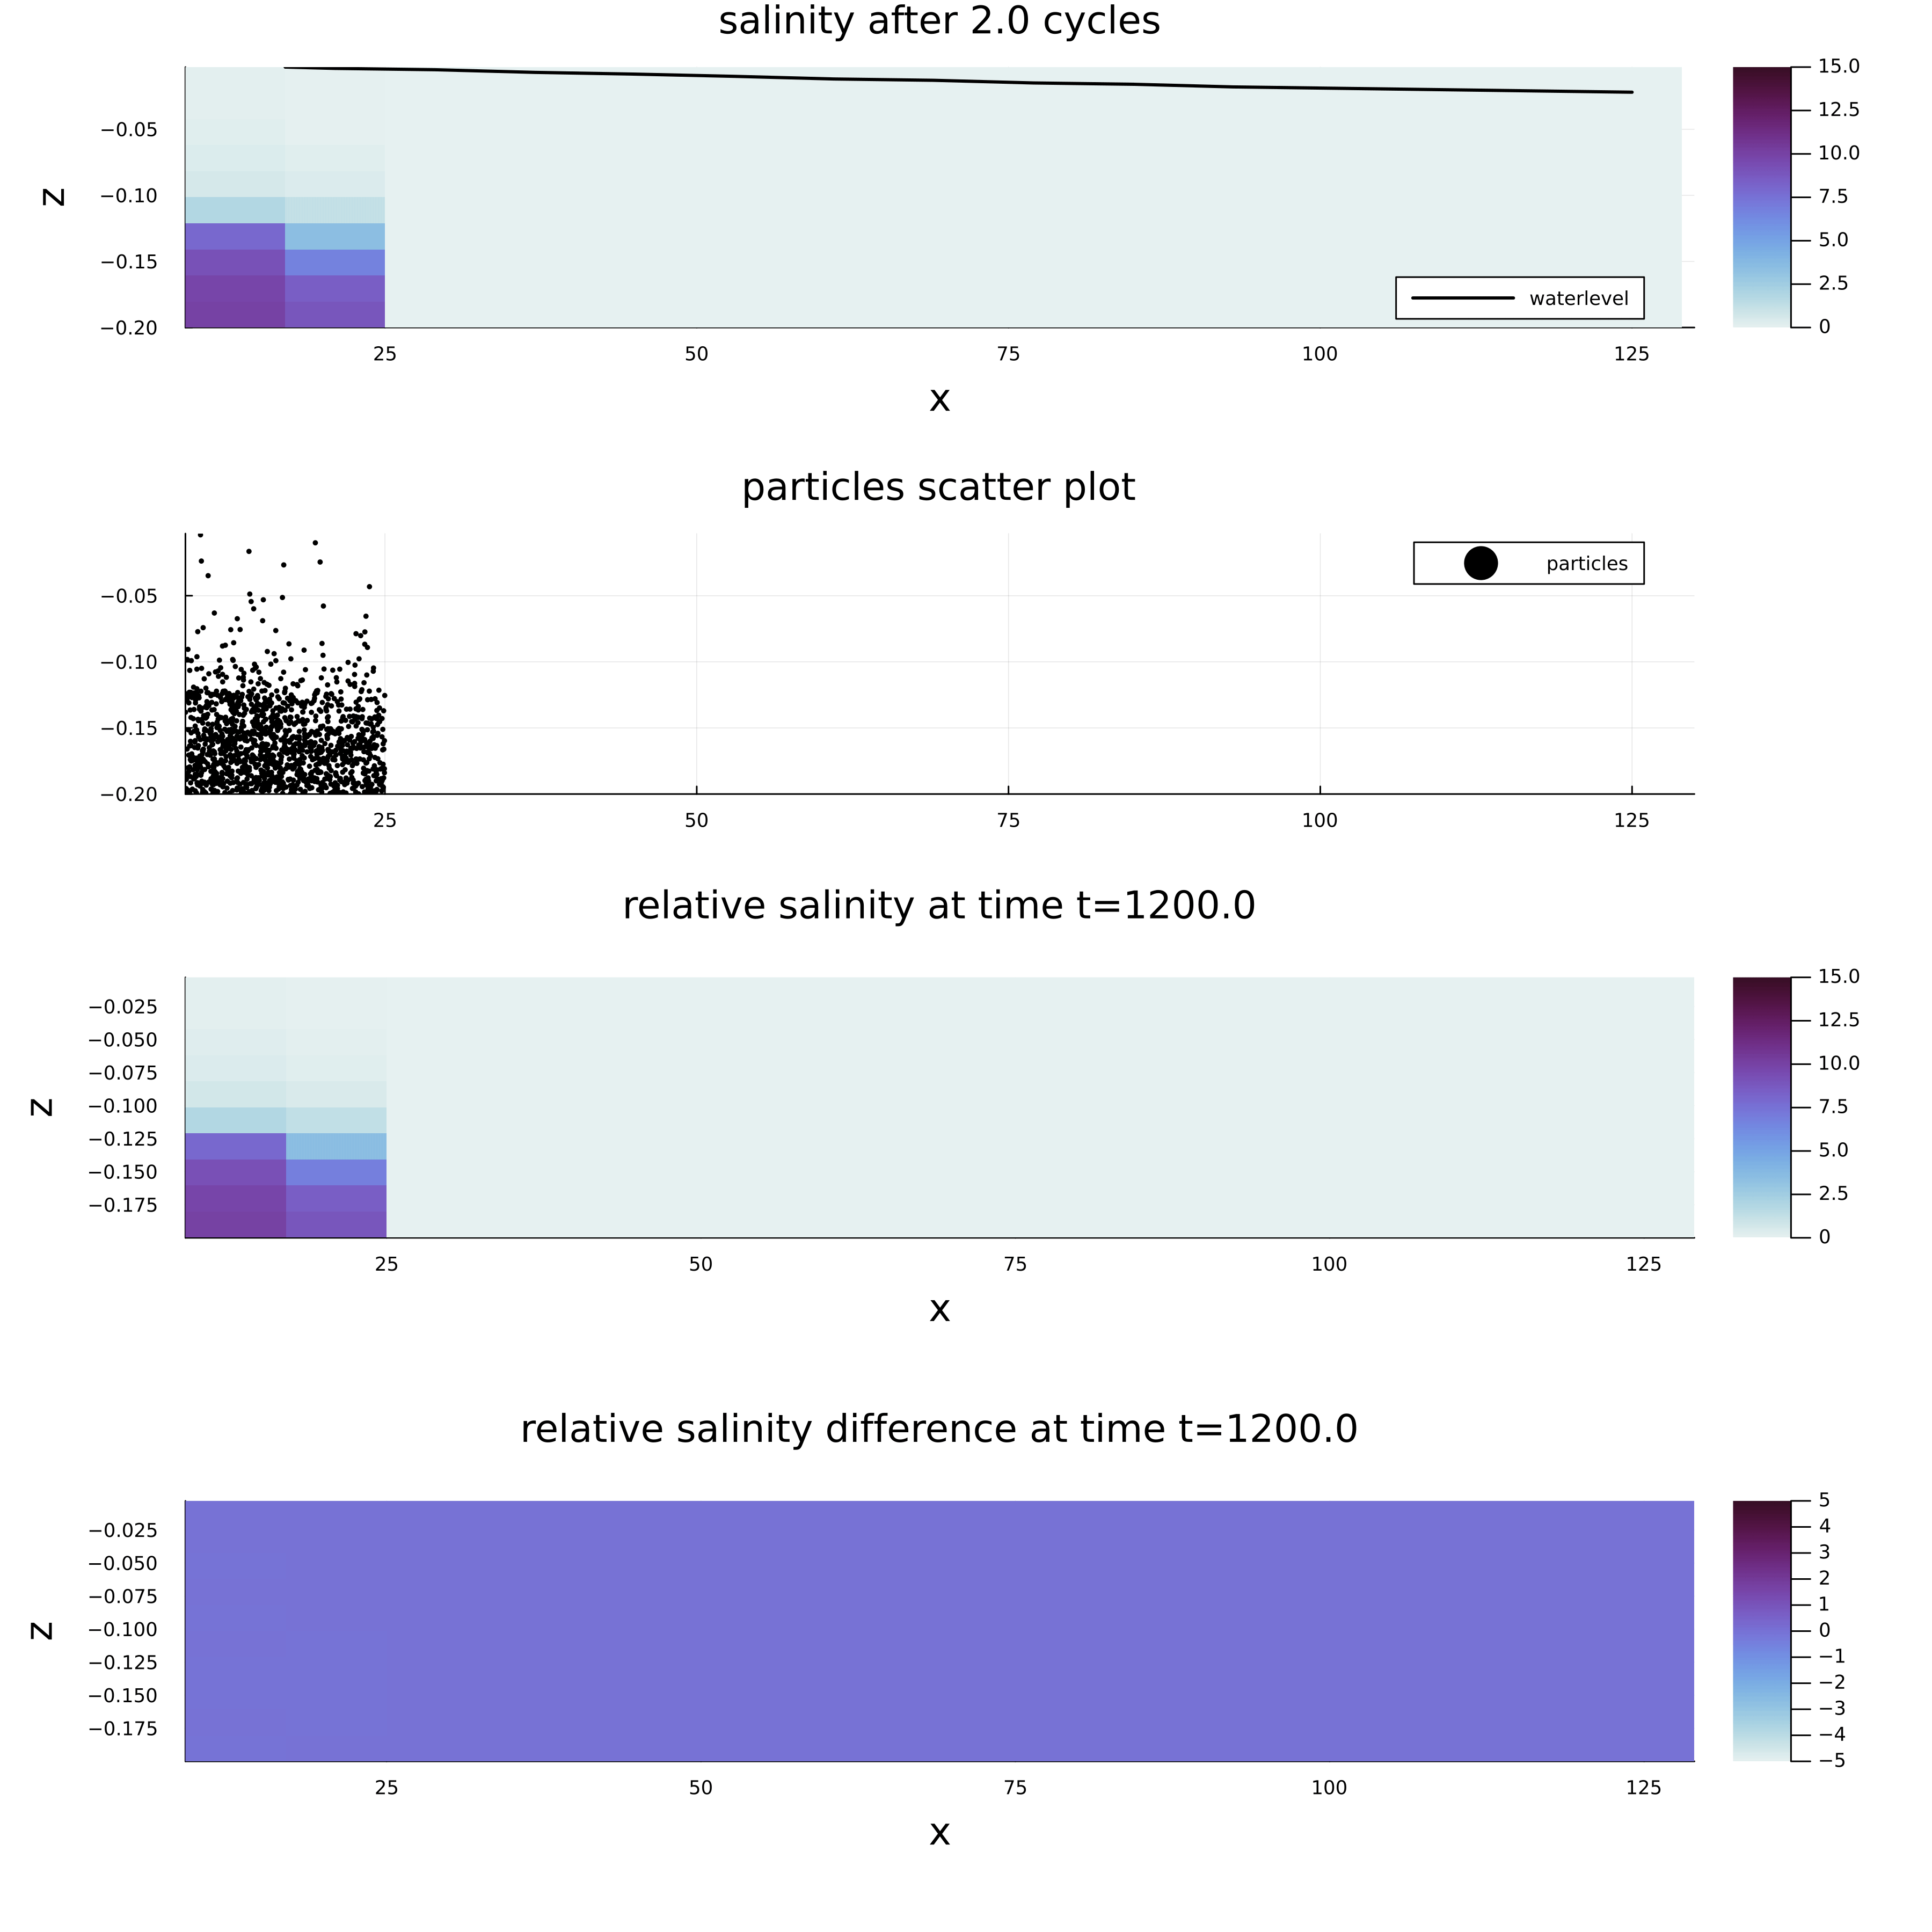

In [85]:
# create an animation of the approximate salinity field
t_points = range(t_start, stop = t_stop-t_step, step = t_step)
z_points = range(z_bottom,stop=z_surface,length=N_grid+1)
x_points = range(x_left, x_right, step=d["dx"])
zc_points = (z_points[1:end-1] + z_points[2:end]) ./2
xc_points = (x_points[1:end-1] + x_points[2:end]) ./2

concentration_field = zeros(length(z_points)-1, length(x_points)-1)


anim_sapprox = @animate for t in t_points
    l = @layout([a;b;c;d])

    # compute salinity and water level from data
    s_interp = [s(x,y_middle,z,t) for x in xc_points, z in zc_points]' # salinity
    h_interp = [h(x,y_middle,0.0,t) for x in xc_points] # water level
    p1=heatmap(xc_points,zc_points,s_interp,xlabel="x",ylabel="z",title="salinity after $(t/600.0) cycles",label="salinity",clims=(0,15),color=:dense,xlims=(x_left,x_right),ylims=(z_bottom,z_surface))
    plot!(p1,xc_points,h_interp,linewidth=2,color=:black,label="waterlevel", 
         left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, right_margin = 5Plots.mm,
         titlefontsize=16,xguidefontsize=16, yguidefontsize=16)
    # add particles
    itime=findmin(abs.(t.-d["keep_particle_times"]))[2] + 1 # important to add one here because the first output is the one only with initialization
                                                            # findmin returns both min value and index, specify 2 will return the required index
    age=d["all_particles"][itime][4,:] # in cycles ~ 10 minutes
    #println("time=$(t/600.0) cycles, age=$(sum(age)/length(age))")
    p2=scatter(d["all_particles"][itime][1,:],d["all_particles"][itime][3,:],zcolor=age,clims=(0,t-t_start),xlims=(x_left,x_right),ylims=(z_bottom,z_surface),markersize=0.5,label="particles",
              left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, right_margin = 5Plots.mm, title="particles scatter plot",
              titlefontsize=16,xguidefontsize=16, yguidefontsize=16)

    # get salinity from data
    particles_itime = d["all_particles"][itime]
    _,NumParticles = size(particles_itime) 
    sc_approx = calculate_Npart_field(x_points, z_points, particles_itime, trues(NumParticles)) ./ Npart_per_salinity
    p8 = heatmap(xc_points, zc_points, sc_approx, xlabel="x", ylabel="z", title="relative salinity at time t=$t", clim=(0,15), color=:dense, label="salinity", legend=true,
                 left_margin = 5Plots.mm, bottom_margin = 10Plots.mm, right_margin = 5Plots.mm, top_margin = 5Plots.mm,
                 titlefontsize=16,xguidefontsize=16, yguidefontsize=16)
    
    s_err = s_interp .- sc_approx
    p9 = heatmap(xc_points, zc_points, s_err, xlabel="x", ylabel="z", title="relative salinity difference at time t=$t", clim=(-5,5), color=:dense, label="salinity", legend=true,
    left_margin = 5Plots.mm, bottom_margin = 10Plots.mm, right_margin = 5Plots.mm, top_margin = 5Plots.mm,
    titlefontsize=16,xguidefontsize=16, yguidefontsize=16)

    println("At t=$(t), smass_approx=",sum(abs.(sc_approx[:,2:end])) * d["dx"] * 1 * (z_surface-z_bottom)/N_grid,
            ", smass_true=",sum(abs.(s_interp[:,2:end])) * d["dx"] * 1 * (z_surface-z_bottom)/N_grid )

    plot(p1,p2,p8, p9,size=(1200,1200),layout=l, dpi=300)
end
gif(anim_sapprox, "./$(dirname)/s_RK4=$(IS_USE_RK4)_dx=$(d["dx"])_dt=$(d["dt"])_N_grid=$(N_grid).gif", fps=1)

In [86]:
# calculate the evolution of error
function calculate_error(t_points, x_points, xc_points, z_points, zc_points, d)
    error = zeros(length(t_points))
    mass_approx = zeros(length(t_points))
    mass_true = zeros(length(t_points))
    for i in eachindex(t_points)
        t = t_points[i]
        itime=findmin(abs.(t.-d["keep_particle_times"]))[2] + 1
        particles_itime = d["all_particles"][itime]
        _,NumParticles = size(particles_itime) 
        sc_approx = calculate_Npart_field(x_points, z_points, particles_itime, trues(NumParticles)) ./ Npart_per_salinity
        s_interp = [s(x,y_middle,z,t) for x in xc_points, z in zc_points]' # salinity
        error[i] = sum(abs.(sc_approx[:,2:end] .- s_interp[:,2:end])) * d["dx"] * 1 * (z_surface-z_bottom)/N_grid # start from the second column of the salinity field to omit forcing layer
        mass_approx[i] = sum(sc_approx[:,2:end]) * d["dx"] * 1 * (z_surface-z_bottom)/N_grid
        mass_true[i] = sum(s_interp[:,2:end]) * d["dx"] * 1 * (z_surface-z_bottom)/N_grid
    end
    return error, mass_true, mass_approx
end
fname = ".\\tidal_flume_err_N_grid=$(N_grid)_dx=$(d["dx"]).txt"
error_evo, mass_true, mass_approx = calculate_error(t_points, x_points, xc_points, z_points, zc_points, d)
open(fname, "w") do io
    writedlm(io, hcat(error_evo, mass_true, mass_approx))
end

p = plot(layout=(1,2),size=(900,400),margin=10Plots.mm)
plot!(p, t_points, error_evo, subplot=1, ylim=(0,160), label="salinity mass difference", xlabel="t", ylabel=L"salinity mass difference $\Delta m_s(t)$",
     left_margin = 5Plots.mm, bottom_margin = 10Plots.mm, right_margin = 5Plots.mm, top_margin = 5Plots.mm,
     linewdith=2, titlefontsize=16,xguidefontsize=14, yguidefontsize=14)
plot!(p, t_points, mass_approx, subplot=2, ylim=(0,160), label=" from particles", xlabel="t", ylabel=L"total salinity mass $m_s(t)$",
left_margin = 5Plots.mm, bottom_margin = 10Plots.mm, right_margin = 5Plots.mm, top_margin = 5Plots.mm,
      linewidth=2)
plot!(p, t_points, mass_true, subplot=2, ylim=(0,160), label="from data",
left_margin = 5Plots.mm, bottom_margin = 10Plots.mm, right_margin = 5Plots.mm, top_margin = 5Plots.mm,
     linewidth=2, titlefontsize=16,xguidefontsize=14, yguidefontsize=14)

savefig(p, "./$(dirname)/errevo_sl_RK4=$(IS_USE_RK4)_dx=$(d["dx"])_dt=$(d["dt"])_N_grid=$(N_grid).png")


"d:\\Projects\\particles.jl\\case_tidal_flume\\flux\\errevo_sl_RK4=false_dx=8.0_dt=1.0_N_grid=10.png"

In [87]:
d["all_particles"][end]

4×2029 Matrix{Float64}:
  19.0617     20.0674     18.5721   …   9.00435     9.09238     9.07203
   1.0         1.0         1.0          1.0         1.0         1.0
  -0.196221   -0.187602   -0.19961     -0.0754652  -0.0503457  -0.0382575
 600.0       600.0       600.0          0.0         0.0         0.0

┌ Info: Saved animation to d:\Projects\particles.jl\case_tidal_flume\flux\uvel_heatmap_x=65.gif
└ @ Plots C:\Users\hugo1\.julia\packages\Plots\3BCH5\src\animation.jl:156


Plots.AnimatedGif("d:\\Projects\\particles.jl\\case_tidal_flume\\flux\\uvel_heatmap_x=65.gif")
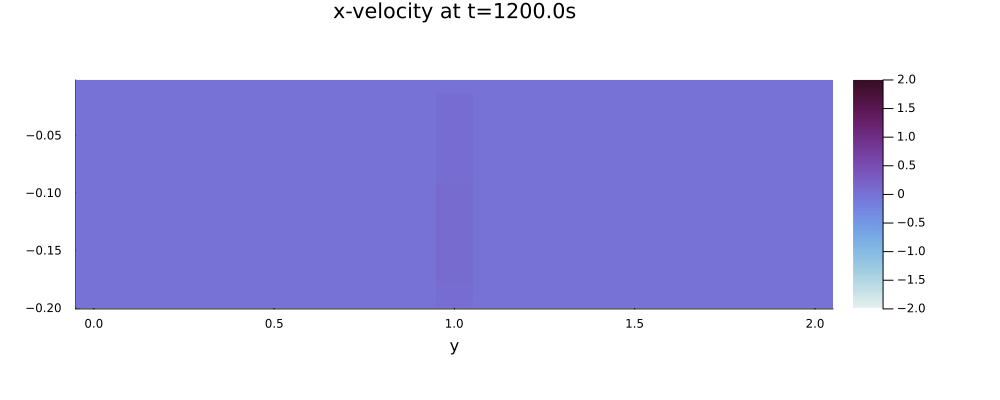

In [88]:
u_interp_map = zeros(4,1)
t_points = range(t_start, stop = t_stop-t_step, step = t_step)
z_points = range(z_bottom,stop=z_surface,length=100)
y_points = range(0,2, length=21)
xcor = 65

anim_uheatmap = @animate for t in t_points
    f = plot()
    u_interp_map = [u(xcor,y,z,t) for z in z_points, y in y_points]
    heatmap!(f, y_points, z_points, u_interp_map,xlabel="y",zlabel="z",title="x-velocity at t=$(t)s",clims=(-2,2),color=:dense,legend=false)
    plot(f, size=(1000,400), left_margin = 5Plots.mm, bottom_margin = 15Plots.mm, right_margin = 15Plots.mm, top_margin = 15Plots.mm)
end
gif(anim_uheatmap, ".\\$(dirname)\\uvel_heatmap_x=$(xcor).gif", fps=4)


3×4 Matrix{Int64}:
 2  3  4  5
 3  4  5  6
 4  5  6  7

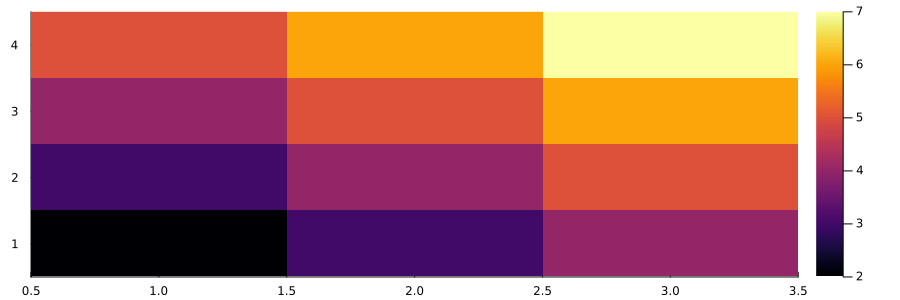

In [90]:
#a = [[i+j for i in range(1,3)] for j in range(1,4)]
a = [i+j for i in range(1,3), j in range(1,4)]
display(a)
rowlen, collen = size(a)
p4 = heatmap(range(1, rowlen), range(1, collen), a')

In [91]:
# plot the salintiy and x-velocity profile that varies with time at certain x
#N_zgrid = 40 #check its definition near d["dx"]
Δz = (z_surface - z_bottom) / N_grid
t_points = range(start=0.0, stop=6000.0, step = 10.0)
z_points = range(z_bottom,stop=z_surface,length=N_grid)
V_rate = similar(t_points)
u_prof = zeros(length(z_points), length(t_points))
s_prof = zeros(length(z_points), length(t_points))
xcor = 9

for i in 1:length(t_points)
    t = t_points[i]
    u_prof_ti = [u(xcor,y_middle,z,t) for z in z_points]
    u_prof[:, i] = u_prof_ti
    s_prof[:, i] = [s(xcor,y_middle,z,t) for z in z_points] 
    V_rate[i] =  sum(u_prof_ti)*Δz
end
p1 = plot(t_points, V_rate, label="water flux", title="Water flux per unit span and per second")
p2 = heatmap(t_points, z_points, u_prof, title="horizontal velocity profile at x=$(xcor)")
p3 = heatmap(t_points, z_points, s_prof, title="salinity profile at x=$(xcor)")
l = @layout([a; b; c])
plot(p1,p2,p3, layout=l, size=(1200,600), dpi=300)
savefig("./$(dirname)/forcing_layer_RK4=$(IS_USE_RK4)_dx=$(d["dx"])_dt=$(d["dt"])_N_grid=$(N_grid).png")



"d:\\Projects\\particles.jl\\case_tidal_flume\\flux\\forcing_layer_RK4=false_dx=8.0_dt=1.0_N_grid=10.png"

In [93]:
# create a heatmap of the salinity intrusion length that varies with time and depth 
t_points = range(t_start, stop = t_stop-t_step, step = t_step)
z_points = range(z_bottom,stop=z_surface,length=N_grid+1)
x_points = range(x_left, x_right, step=d["dx"])
zc_points = (z_points[1:end-1] + z_points[2:end]) ./2
xc_points = (x_points[1:end-1] + x_points[2:end]) ./2

function get_intru_location(t_points, zc_points, s_lowbound)
    s_intru_location = zeros(length(z_points)-1, length(t_points))
    for i in eachindex(t_points)
        t = t_points[i]
        for j in eachindex(zc_points)
            z = zc_points[j]
            s_ti_zcj = [s(x, y_middle, z, t) for x in xc_points]
            id = findlast(s_ti_zcj .>= s_lowbound) 
            if id==nothing
                s_intru_location[j, i] = xcor
            else
                s_intru_location[j, i] = xc_points[id] 
            end
        end
    end
    return s_intru_location
end

s_lowbound = 2.0
s_intru_location = get_intru_location(t_points, zc_points, s_lowbound)
s_intru = (s_intru_location .- xcor) ./ (x_right-x_left)
p11 = heatmap(t_points,zc_points, s_intru, xlabel="t", ylabel="z", clim=(0,0.4),
            left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, right_margin = 5Plots.mm, top_margin=5Plots.mm, title=L"SL_{2} / L_{channel}")


s_lowbound2 = 6.0
s_intru_location = get_intru_location(t_points, zc_points, s_lowbound2)
s_intru2 = (s_intru_location .- xcor) ./ (x_right-x_left)
p12 = heatmap(t_points,zc_points, s_intru2, xlabel="t", ylabel="z",clim=(0,0.4),
            left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, right_margin = 5Plots.mm, top_margin=5Plots.mm, title=L"SL_{6} / L_{channel}")


s_lowbound2 = 10.0
s_intru_location = get_intru_location(t_points, zc_points, s_lowbound2)
s_intru3 = (s_intru_location .- xcor) ./ (x_right-x_left)
p13 = heatmap(t_points,zc_points, s_intru3, xlabel="t", ylabel="z",clim=(0,0.4),
            left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, right_margin = 5Plots.mm, top_margin=5Plots.mm, title=L"SL_{10} / L_{channel}")

            
l_intru = @layout([a;b;c])
plot(p11,p12,p13, size=(1200,600), dpi=300, layout=l_intru)
savefig("./$(dirname)/salt_intru_length_slb_RK4=$(IS_USE_RK4)_dx=$(d["dx"])_dt=$(d["dt"])_N_grid=$(N_grid).png")


"d:\\Projects\\particles.jl\\case_tidal_flume\\flux\\salt_intru_length_slb_RK4=false_dx=8.0_dt=1.0_N_grid=10.png"

In [95]:
# plot the heatmap of salinity versus time and location x (avg in the vertical direction)

# true solution

# particle solution

# intrusion length 



In [96]:
# plot the distribution of residence time of particle